## 데이터 준비

In [1]:
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms

In [2]:
train = datasets.MNIST(
    '../data', train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
    ]),
)
test = datasets.MNIST(
    '../data', train=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
    ]),
)

In [3]:
def plot(x):
    img = (np.array(x.detach().cpu(), dtype='float')).reshape(28,28)

    plt.imshow(img, cmap='gray')
    plt.show()

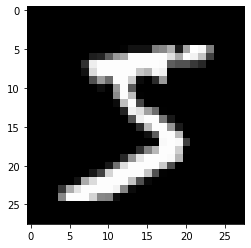

In [4]:
plot(train.data[0])


In [5]:
x = train.data.float() / 255
y = train.targets

x = x.view(x.size(0), -1)
print(x.shape, y.shape)

torch.Size([60000, 784]) torch.Size([60000])


In [6]:
input_size = x.size(-1)
output_size = int(max(y)) + 1
print('input_size : %d, output_size:%d' % (input_size, output_size))

input_size : 784, output_size:10


In [7]:
# Train/ valid ratio
ratios = [.8, .2]

train_cnt = int(x.size(0) * ratios[0])
valid_cnt = int(x.size(0) * ratios[1])
test_cnt = len(test.data)
cnts = [train_cnt, valid_cnt]

print('Train %d / Valid %d Test %d samples.' % (train_cnt, valid_cnt, test_cnt))

indices = torch.randperm(x.size(0))

x = torch.index_select(x, dim=0, index=indices)
y = torch.index_select(y, dim=0, index=indices)

x = list(x.split(cnts, dim=0))
y = list(y.split(cnts, dim=0))

x += [(test.data.float()/255.).view(test_cnt, -1)]
y += [test.targets]

for x_i, y_i in zip(x,y):
  print(x_i.size(), y_i.size())

Train 48000 / Valid 12000 Test 10000 samples.
torch.Size([48000, 784]) torch.Size([48000])
torch.Size([12000, 784]) torch.Size([12000])
torch.Size([10000, 784]) torch.Size([10000])


In [8]:
model = nn.Sequential(
    nn.Linear(input_size, 500),
    nn.LeakyReLU(),
    nn.Linear(500, 400),
    nn.LeakyReLU(),
    nn.Linear(400, 300),
    nn.LeakyReLU(),
    nn.Linear(300, 200),
    nn.LeakyReLU(),
    nn.Linear(200,100),
    nn.LeakyReLU(),
    nn.Linear(100,50),
    nn.LeakyReLU(),
    nn.LeakyReLU(),
    nn.Linear(50, output_size),
    nn.LogSoftmax(dim=-1),
)

- 이렇게 선얺나 모델의 가중치 파라미터를 아담 옵티마이저에 등록하고 NLL 손실함수도 선언한다.
- NLL 손실 함수를 사용하기 위해서 로그소프트맥스 함수를 모델 마지막에 사용한것에 대해서 주목해야한다.

In [9]:
optimizer = optim.Adam(model.parameters())
crit = nn.NLLLoss()

In [10]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')

In [11]:
model = model.to(device)

x = [x_i.to(device) for x_i in x]
y = [y_i.to(device) for y_i in y]

In [12]:
n_epochs = 1000
batch_size = 256
print_interval = 10

lowest_loss = np.inf
best_model = None

early_stop = 50
lowest_epoch = np.inf

In [14]:
from tqdm import tqdm
train_history, valid_history = [], []

for i in tqdm(range(n_epochs)):
    indices = torch.randperm(x[0].size(0)).to(device)
    x_ = torch.index_select(x[0], dim=0, index=indices)
    y_ = torch.index_select(y[0], dim=0, index=indices)
    
    x_ = x_.split(batch_size, dim=0)
    y_ = y_.split(batch_size, dim=0)
    
    train_loss, valid_loss = 0, 0
    y_hat = []
    
    for x_i, y_i in zip(x_, y_):
        y_hat_i = model(x_i)
        loss = crit(y_hat_i, y_i.squeeze())

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()        
        train_loss += float(loss) # This is very important to prevent memory leak.

    train_loss = train_loss / len(x_)
        
    with torch.no_grad():
        x_ = x[1].split(batch_size, dim=0)
        y_ = y[1].split(batch_size, dim=0)
        
        valid_loss = 0
        
        for x_i, y_i in zip(x_, y_):
            y_hat_i = model(x_i)
            loss = crit(y_hat_i, y_i.squeeze())
            
            valid_loss += float(loss)
            
            y_hat += [y_hat_i]
            
    valid_loss = valid_loss / len(x_)
    
    train_history += [train_loss]
    valid_history += [valid_loss]
        
    if (i + 1) % print_interval == 0:
        print('Epoch %d: train loss=%.4e  valid_loss=%.4e  lowest_loss=%.4e' % (
            i + 1,
            train_loss,
            valid_loss,
            lowest_loss,
        ))
        
    if valid_loss <= lowest_loss:
        lowest_loss = valid_loss
        lowest_epoch = i
        
        best_model = deepcopy(model.state_dict())
    else:
        if early_stop > 0 and lowest_epoch + early_stop < i + 1:
            print("There is no improvement during last %d epochs." % early_stop)
            break

print("The best validation loss from epoch %d: %.4e" % (lowest_epoch + 1, lowest_loss))
model.load_state_dict(best_model)

  1%|          | 10/1000 [00:55<1:41:33,  6.16s/it]

Epoch 10: train loss=1.8160e-02  valid_loss=1.1517e-01  lowest_loss=1.0417e-01


  2%|▏         | 20/1000 [01:49<1:27:25,  5.35s/it]

Epoch 20: train loss=1.1698e-02  valid_loss=1.3998e-01  lowest_loss=1.0417e-01


  3%|▎         | 30/1000 [02:45<1:30:14,  5.58s/it]

Epoch 30: train loss=5.3976e-03  valid_loss=1.2922e-01  lowest_loss=1.0417e-01


  4%|▍         | 40/1000 [03:41<1:34:21,  5.90s/it]

Epoch 40: train loss=5.6983e-03  valid_loss=1.3632e-01  lowest_loss=1.0417e-01


  5%|▌         | 50/1000 [04:32<1:19:54,  5.05s/it]

Epoch 50: train loss=5.0647e-03  valid_loss=1.4245e-01  lowest_loss=1.0417e-01


  5%|▌         | 53/1000 [04:52<1:27:07,  5.52s/it]

There is no improvement during last 50 epochs.
The best validation loss from epoch 4: 1.0417e-01


<All keys matched successfully>

## 손실 곡선 확인

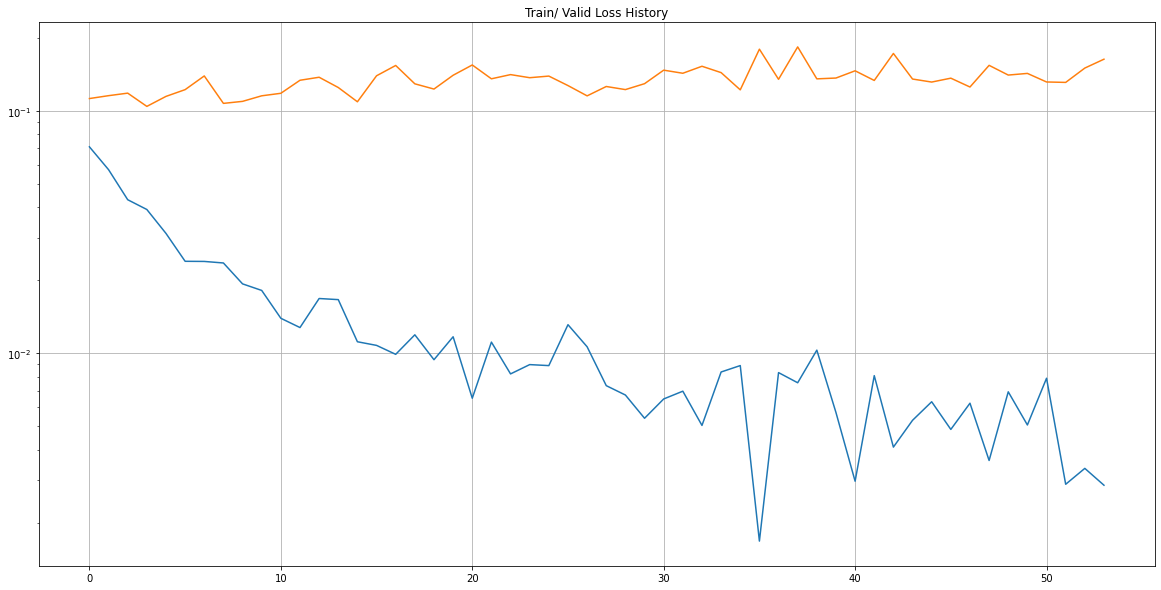

In [15]:
plot_from = 0

plt.figure(figsize=(20, 10))
plt.grid(True)
plt.title('Train/ Valid Loss History')
plt.plot(
    range(plot_from, len(train_history)), train_history[plot_from:],
    range(plot_from, len(valid_history)), valid_history[plot_from:],
)
plt.yscale('log')
plt.show()

## 결과 확인 

In [16]:
test_loss = 0
y_hat = []

with torch.no_grad():
    x_ = x[-1].split(batch_size, dim=0)
    y_ = y[-1].split(batch_size, dim=0)

    for x_i, y_i in zip(x_, y_):
        y_hat_i = model(x_i)
        loss = crit(y_hat_i, y_i.squeeze())

        test_loss += loss

        y_hat += [y_hat_i]

test_loss = test_loss / len(x_)
y_hat = torch.cat(y_hat, dim=0)

print('Test loss : %.4e' % test_loss)

Test loss : 8.6562e-02


- 분류 문제를 다루고 있으므로 신경망의 마지막 계층은 확률 값 또는 로그 확률 값으로 나타내고 있ㅇ르 것이다.
- 따라서 마지막 계층 출력값 중 가장 높은 값을 가지고 있는 클래스 인덱스가 모델이 예측한 클래스의 인덱스라고 볼 수 있다.

In [17]:
correct_cnt = (y[-1].squeeze() == torch.argmax(y_hat, dim=-1)).sum()
total_cnt = float(y[-1].size(0))

print('Test Accuracy %.4f' % (correct_cnt / total_cnt))

Test Accuracy 0.9750


In [18]:
import pandas as pd
from sklearn.metrics import confusion_matrix

In [19]:
pd.DataFrame(confusion_matrix(y[-1], torch.argmax(y_hat, dim=-1)),
            index = ['true_%d' % i for i in range(10)],
            columns=['pred_%d' % i for i in range(10)])

,pred_0,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,pred_7,pred_8,pred_9
true_0,971,0,2,0,0,0,1,1,3,2
true_1,0,1119,2,1,0,1,1,1,10,0
true_2,3,2,1005,5,0,0,2,10,4,1
true_3,0,0,4,984,0,6,0,4,4,8
true_4,0,0,4,0,952,0,7,1,3,15
true_5,3,0,0,5,1,867,5,1,7,3
true_6,11,4,4,0,3,3,932,0,1,0
true_7,2,2,4,2,1,0,0,999,2,16
true_8,2,0,5,8,4,3,2,2,937,11
true_9,2,2,0,3,9,3,0,1,5,984


- 7을 9로 헷갈리는 경우는 많지만
- 9를 7로 헷갈리는 경우는 많지않다